In [1]:
import math
import time
import os
import urllib2

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from slim.nets import inception
from slim.preprocessing import inception_preprocessing

# Main slim library
from tensorflow.contrib import slim

In [3]:
from time import sleep
sleep(5)

>> Downloading inception_v1_2016_08_28.tar.gz 100.0%
Successfully downloaded inception_v1_2016_08_28.tar.gz 24642554 bytes.


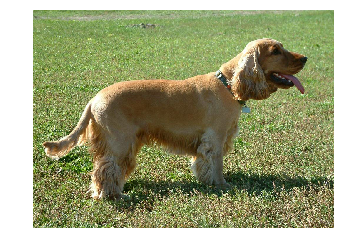

Probability 45.14% => [cocker spaniel, English cocker spaniel, cocker]
Probability 21.55% => [Sussex spaniel]
Probability 10.37% => [Irish setter, red setter]
Probability 5.06% => [Welsh springer spaniel]
Probability 2.99% => [clumber, clumber spaniel]


In [5]:
url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

image_size = inception.inception_v1.default_image_size

with tf.Graph().as_default():
    url = 'https://upload.wikimedia.org/wikipedia/commons/7/70/EnglishCockerSpaniel_simon.jpg'
    image_string = urllib2.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(processed_images, num_classes=1001, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
        slim.get_model_variables('InceptionV1'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        tmp = probabilities
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index]))

## First model with tf.slim

In [28]:
def regression_model(inputs, is_training=True, scope='deep_regression'):
    end_points = {}
    with tf.variable_scope(scope, 'deep_regression', [inputs]):
        with slim.arg_scope([slim.fully_connected], 
                               activation_fn=tf.nn.relu,
                               weights_regularizer=slim.l2_regularizer(0.01)):
            a1 = slim.fully_connected(inputs, 32, scope='fc1')
            end_points['fc1'] = a1
            a1_drop = slim.dropout(a1, 0.8, is_training=is_training)
            a2 = slim.fully_connected(a1_drop, 16, scope='fc2')
            end_points['fc2'] = a2
            predictions = slim.fully_connected(a2, 1, activation_fn=None, scope='predictions')
            end_points['predictions'] = predictions
            
    return predictions, end_points

In [30]:
with tf.Graph().as_default():
    inputs = tf.placeholder(tf.float32, shape=[None, 1])
    outputs = tf.placeholder(tf.float32, shape=[None, 1])
    
    predictions, end_points = regression_model(inputs)
    
    print('Layers')
    for k, v in end_points.items():
        print('name = {0}, shape = {1}'.format(v.name, v.get_shape()))
    
    print('\n')
    print('Parameters')
    for v in slim.get_model_variables():
        print('name = {0}, shape = {1}'.format(v.name, v.get_shape()))

Layers
name = deep_regression/fc1/Relu:0, shape = (?, 32)
name = deep_regression/fc2/Relu:0, shape = (?, 16)
name = deep_regression/predictions/BiasAdd:0, shape = (?, 1)


Parameters
name = deep_regression/fc1/weights:0, shape = (1, 32)
name = deep_regression/fc1/biases:0, shape = (32,)
name = deep_regression/fc2/weights:0, shape = (32, 16)
name = deep_regression/fc2/biases:0, shape = (16,)
name = deep_regression/predictions/weights:0, shape = (16, 1)
name = deep_regression/predictions/biases:0, shape = (1,)


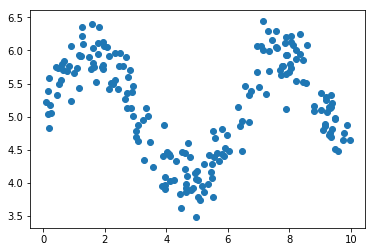

In [27]:
def produce_batch(batch_size, noise=0.3):
    x = np.random.random([batch_size, 1]) * 10
    y = np.sin(x) + 5 + np.random.randn(batch_size, 1) * noise
    return x.astype(np.float32), y.astype(np.float32)

x_train, y_train = produce_batch(200)
x_test, y_test = produce_batch(200)
plt.scatter(x_train, y_train)
plt.show()

In [37]:
def convert_data_to_tensors(x, y):
    inputs = tf.constant(x)
    inputs.set_shape([None, 1])
    
    outputs = tf.constant(y)
    outputs.set_shape([None, 1])
    return inputs, outputs

In [35]:
ckpt_dir = '/tmp/regression_model/'

with tf.Graph().as_default():
    inputs, outputs = convert_data_to_tensors(x_train, y_train)
    predictions, nodes = regression_model(inputs)
    loss = tf.losses.mean_squared_error(labels=outputs, predictions=predictions)
    # User loss + regularization loss
    total_loss = slim.losses.get_total_loss()
    
    optimizer = tf.train.AdamOptimizer(0.05)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training inside a session
    final_loss = slim.learning.train(train_op, 
                                     logdir=ckpt_dir,
                                     number_of_steps=5000,
                                     save_summaries_secs=5,
                                     log_every_n_steps=500)
    
print('Finished training. Last batch loss: {0}'.format(final_loss))
print('Checkpoint saved in %s' % ckpt_dir)

Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 500: loss = 0.3382 (0.00 sec/step)
INFO:tensorflow:global step 1000: loss = 0.2343 (0.00 sec/step)
INFO:tensorflow:global step 1500: loss = 0.1980 (0.00 sec/step)
INFO:tensorflow:global step 2000: loss = 0.1852 (0.00 sec/step)
INFO:tensorflow:global step 2500: loss = 0.2023 (0.00 sec/step)
INFO:tensorflow:global_step/sec: 554.226
INFO:tensorflow:global step 3000: loss = 0.1750 (0.00 sec/step)
INFO:tensorflow:global step 3500: loss = 0.1756 (0.00 sec/step)
INFO:tensorflow:global step 4000: loss = 0.1625 (0.00 sec/step)
INFO:tensorflow:global step 4500: loss = 0.1793 (0.00 sec/step)
INFO:tensorflow:global step 5000: loss = 0.1830 (0.00 sec/step)
INFO:tensorflow:

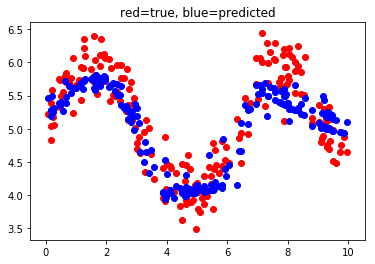

In [40]:
# Load a saved model
with tf.Graph().as_default():
    inputs, outputs = convert_data_to_tensors(x_train, y_train)
    
    predictions, nodes = regression_model(inputs)
    
    # Make a session which restores the parameters from a checkpoint
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        inputs, predictions, outputs = sess.run([inputs, predictions, outputs])
        
plt.scatter(inputs, outputs, c='r')
plt.scatter(inputs, predictions, c='b')
plt.title('red=true, blue=predicted')
plt.show()

# Downloading images

In [ ]:
from datasets.download_images import download_im
dataset_dir = 'data'
# This might issue a warning about EXIL data corrupted
# but these info are not useful for our task anyway.
download_im('sad', 0, 100, dataset_dir)

In [2]:
from text_model.text_preprocessing import _load_embedding_weights_glove, preprocess_one_df

emb_name = 'glove'
text_dir = 'text_model'
emb_dir = 'embedding_weights'
filename = 'glove.6B.50d.txt'

vocabulary, embedding = _load_embedding_weights_glove(text_dir, emb_dir, filename)

_POST_SIZE = 200

Finished loading word embedding weights.


In [28]:
search_query = 'angry'
df = preprocess_one_df(vocabulary, embedding, search_query, _POST_SIZE)
print(df.shape)

(59899, 12)


In [29]:
import pandas as pd
pd.isnull(df['photo']).sum()

39070

In [30]:
113936 / 5

22787

In [10]:
{'happy': 116930,
 'sad': 66747,
 'angry': 59899,
 'surprised': 8625,
 'scared': 67756,
 'disgusted': 6349}

{'angry': 59899,
 'disgusted': 6349,
 'happy': 116930,
 'sad': 66747,
 'scared': 67756,
 'surprised': 8625}

In [18]:
import numpy as np
np.linspace(9000, 60000, 7, dtype=int)

array([ 9000, 17500, 26000, 34500, 43000, 51500, 60000])

# Converting raw data to TFRecord

In [1]:
from datasets.convert_images_tfrecords import convert_images
dataset_dir = 'data'
convert_images(dataset_dir, 50)

>> Converting image 503/503 shard 4
>> Converting image 50/50 shard 4

Finished converting the dataset!


# Loading dataset

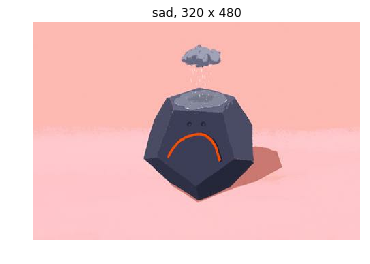

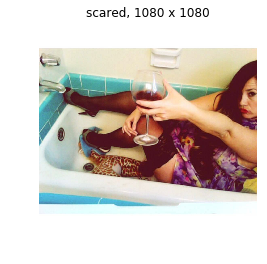

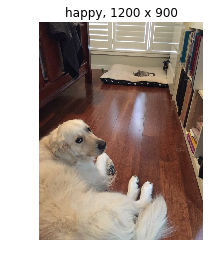

In [3]:
from datasets.convert_to_dataset import get_split
import tensorflow as tf
from tensorflow.contrib import slim
import matplotlib.pyplot as plt
%matplotlib inline

with tf.Graph().as_default(): 
    dataset_dir = 'data'
    dataset = get_split('train', dataset_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1, shuffle=False)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(3):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

# Tune inception model on Tumblr data

In [2]:
import tensorflow as tf
from image_model.image_model import download_pretrained_model

checkpoints_dir = 'image_model/pretrained_model'
if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)
    # Download pre-trained model
    url = 'http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz'
    download_pretrained_model(url, checkpoints_dir)

In [1]:
from image_model.image_model import fine_tune_model
dataset_dir = 'data'
checkpoints_dir = 'image_model/pretrained_model'
train_dir = 'image_model/fine_tuned_model'

fine_tune_model(dataset_dir, checkpoints_dir, train_dir, num_steps=2)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 1: loss = 1.4969 (29.01 sec/step)
Step 0: loss: 1.497, validation accuracy: 0.480
INFO:tensorflow:global step 2: loss = 2.3375 (16.44 sec/step)
Step 1: loss: 2.338, validation accuracy: 0.480
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.
Finished training. Last batch loss 2.338


# Reuse fine-tuned model

Instructions for updating:
Use `tf.local_variables_initializer` instead.


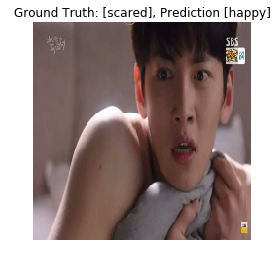

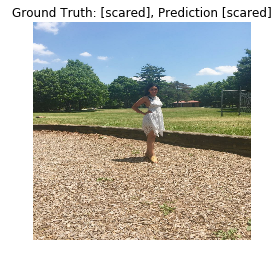

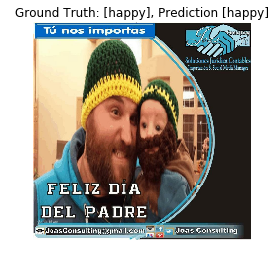

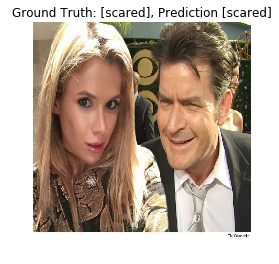

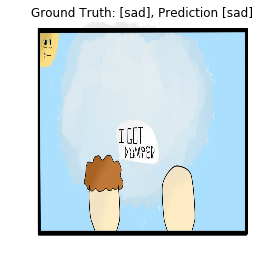

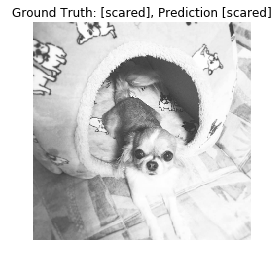

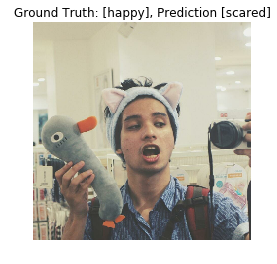

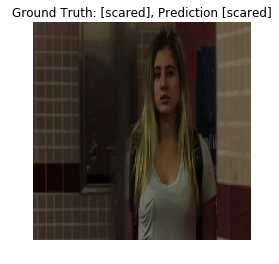

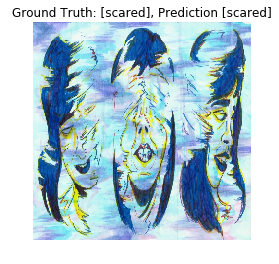

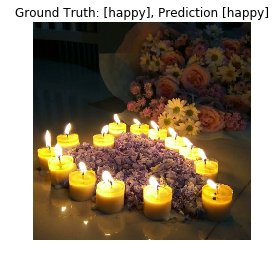

In [6]:
import numpy as np
import tensorflow as tf

from slim.nets import inception
from datasets.convert_to_dataset import get_split
from image_model.image_model import _load_batch
from tensorflow.contrib import slim
import matplotlib.pyplot as plt
%matplotlib inline

image_size = inception.inception_v1.default_image_size
batch_size = 10
dataset_dir = 'data'
train_dir = 'image_model/fine_tuned_model'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = get_split('train', dataset_dir)
    images, images_raw, labels = _load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()

In [14]:
print('hi {0:.3f}'.format(1.0))

hi 1.000


In [3]:
import numpy as np
np.vstack([np.arange(5), np.arange(5)])

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

# Comparison with other models

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from datasets.convert_images_tfrecords import get_numpy_data

X_train, X_valid, y_train, y_valid = get_numpy_data('data', 50)
random_seed = 0
logistic = LogisticRegression(multi_class='multinomial', solver='newton-cg',
                              C=1000, random_state=random_seed)
print('Start training Logistic Regression.')
logistic.fit(X_train, y_train)

accuracy_train = accuracy_score(logistic.predict(X_train), y_train)
valid_accuracy = accuracy_score(logistic.predict(X_valid), y_valid)
print('Training accuracy: {0:.3f}'.format(accuracy_train))
print('Validation accuracy: {0:.3f}'.format(valid_accuracy))

Start training LogisticRegression.
Training accuracy: 0.990
Validation accuracy: 0.340


In [3]:
import tensorflow as tf
from tensorflow.contrib import slim
from image_model import inception_v1
images = tf.placeholder(tf.float32, [None, 224, 224, 3])

with slim.arg_scope(inception_v1.inception_v1_arg_scope()):
    logits, _ = inception_v1.inception_v1(images, num_classes=3, is_training=True)

In [4]:
for v in slim.get_model_variables():
    print(v.name, v.get_shape())

(u'InceptionV1/Conv2d_1a_7x7/weights:0', TensorShape([Dimension(7), Dimension(7), Dimension(3), Dimension(64)]))
(u'InceptionV1/Conv2d_1a_7x7/BatchNorm/beta:0', TensorShape([Dimension(64)]))
(u'InceptionV1/Conv2d_1a_7x7/BatchNorm/moving_mean:0', TensorShape([Dimension(64)]))
(u'InceptionV1/Conv2d_1a_7x7/BatchNorm/moving_variance:0', TensorShape([Dimension(64)]))
(u'InceptionV1/Conv2d_2b_1x1/weights:0', TensorShape([Dimension(1), Dimension(1), Dimension(64), Dimension(64)]))
(u'InceptionV1/Conv2d_2b_1x1/BatchNorm/beta:0', TensorShape([Dimension(64)]))
(u'InceptionV1/Conv2d_2b_1x1/BatchNorm/moving_mean:0', TensorShape([Dimension(64)]))
(u'InceptionV1/Conv2d_2b_1x1/BatchNorm/moving_variance:0', TensorShape([Dimension(64)]))
(u'InceptionV1/Conv2d_2c_3x3/weights:0', TensorShape([Dimension(3), Dimension(3), Dimension(64), Dimension(192)]))
(u'InceptionV1/Conv2d_2c_3x3/BatchNorm/beta:0', TensorShape([Dimension(192)]))
(u'InceptionV1/Conv2d_2c_3x3/BatchNorm/moving_mean:0', TensorShape([Dimensi

# Random guessing

Accuracy of random guessing based on the prior probabilities of the classes.

In [25]:
import pandas as pd
import numpy as np
from text_model.text_preprocessing import _load_embedding_weights_glove, preprocess_one_df

_POST_SIZE = 50
df_dict = dict()
emotions = ['happy', 'sad', 'scared', 'angry', 'surprised', 'disgusted', 'annoyed', 'bored', 
'love', 'calm', 'amazed', 'optimistic', 'interested', 'pensive', 'ashamed', 'excited']
emb_name = 'glove'
text_dir = 'text_model'
emb_dir = 'embedding_weights'
filename = 'glove.6B.50d.txt'
if emb_name == 'word2vec':
    vocabulary, embedding = _load_embedding_weights_word2vec(text_dir, emb_dir, filename)
else:
    vocabulary, embedding = _load_embedding_weights_glove(text_dir, emb_dir, filename)
for emotion in emotions:
    df_dict[emotion] = preprocess_one_df(vocabulary, embedding, emotion, _POST_SIZE)

Finished loading word embedding weights.


In [26]:
df_all = pd.concat([df_dict[emotion] for emotion in emotions]).reset_index(drop=True)

In [27]:
df_all.head()

,id,post_url,type,timestamp,date,tags,liked,note_count,photo,text,search_query,text_list,text_len
0,162001283060,https://puusanee.tumblr.com/post/162001283060/...,photo,1497867217,2017-06-19 10:13:37 GMT,"{let, ontheway, happy}",False,0,https://68.media.tumblr.com/7cb924e297a7fb4533...,Because I’m happy Clap along if you know what...,happy,"[113, 400000, 1751, 35675, 385, 83, 81, 346, 1...",23
1,162001248218,http://dishabhanot.tumblr.com/post/16200124821...,photo,1497867100,2017-06-19 10:11:40 GMT,"{johnmayerlyrics, typographydesign, artist, jo...",False,0,https://68.media.tumblr.com/5110bc201bfde30f9f...,I don’t trust myself loving you! #happy #artis...,happy,"[41, 400000, 1853, 3261, 8842, 81, 2131, 40000...",13
2,162001201156,http://carbonandcoalblog.tumblr.com/post/16200...,photo,1497866945,2017-06-19 10:09:05 GMT,"{beautiful, cute, fashion, love, jewellery, cc...",False,1,https://68.media.tumblr.com/bd84d3d9920326002f...,Royalty 👑 💎 Shop @ carbonandcoal.com (Link i...,happy,"[13472, 400000, 400000, 2855, 17527, 400000, 2...",39
3,162001173492,https://thehumorbot.tumblr.com/post/1620011734...,photo,1497866844,2017-06-19 10:07:24 GMT,"{cute, reddit, animals, funny, kitten, wholeso...",False,0,https://68.media.tumblr.com/d05227c0ef9e5be2b0...,dis shoe is too hoovy for the pup via /r/Eyebl...,happy,"[35108, 8597, 14, 317, 400000, 10, 0, 35924, 1...",11
4,162001158834,http://dariayank.tumblr.com/post/162001158834/...,photo,1497866804,2017-06-19 10:06:44 GMT,"{summer, great, good, love, garden, family, fe...",False,0,https://68.media.tumblr.com/2ea4a3278ae49f8d9d...,Хорошо когда появляется стабильность…) два дня...,happy,"[400000, 400000, 400000, 400000, 400000, 40000...",28


In [28]:
total_size = df_all.shape[0]
priors = dict()
for emotion in emotions:
    priors[emotion] = float(df_dict[emotion].shape[0]) / total_size
priors

{'amazed': 0.010873691026413914,
 'angry': 0.10287841080258522,
 'annoyed': 0.09752658309159079,
 'ashamed': 0.010846210524688654,
 'bored': 0.09368446544412784,
 'calm': 0.08898014705503486,
 'disgusted': 0.010904606590854833,
 'excited': 0.03701451829256772,
 'happy': 0.20083094167091756,
 'interested': 0.006028535065978967,
 'love': 0.06885067954128173,
 'optimistic': 0.01757549838466176,
 'pensive': 0.008178884325980582,
 'sad': 0.11464006554099661,
 'scared': 0.11637305468104583,
 'surprised': 0.014813707961273103}

In [29]:
def random_guess(x, priors):
    cum_prob = 0.0
    for emotion in emotions:
        cum_prob += priors[emotion]
        if x < cum_prob:
            return emotion

In [30]:
y_predict = np.array(map(lambda x: random_guess(x, priors), np.random.uniform(size=total_size)))

In [31]:
def permutation(X, y):
    p = np.random.permutation(X.shape[0])
    return X[p], y[p]

In [32]:
y_true = df_all['search_query'].values

In [33]:
y_true, y_predict = permutation(y_true, y_predict)

In [34]:
np.mean(y_true[:int(0.8*total_size)] == y_predict[:int(0.8*total_size)])

0.11077237517819419

# RNN Deep Sentiment

In [20]:
from datasets.download_images import download_im_with_text

download_im_with_text('optimistic', 0, 200, 'data')

Finished loading word embedding weights.


In [21]:
import pandas as pd
from text_model.text_preprocessing import _load_embedding_weights_glove, preprocess_one_df

text_dir = 'text_model'
emb_dir = 'embedding_weights'
filename = 'glove.6B.50d.txt'
vocabulary, embedding = _load_embedding_weights_glove(text_dir, emb_dir, filename)
_POST_SIZE = 50
    
df = preprocess_one_df(vocabulary, embedding, 'optimistic', _POST_SIZE)

Finished loading word embedding weights.


In [24]:
df.iloc[182]['text']

u'\u2018The most beautiful thing we can experience is the mysterious. It is the source of all true art and science.\u2019 - Albert Einstein \U0001f52e I always love to see people take images I make and experiment with them. This one I had to repost because it\u2019s perfect. Connected directly to the Earth, with a mind open to the cosmos and the mystical. \U0001f30c\U0001f64f\U0001f30c If you had a long Monday and need a smile, go have a scroll through the photos of @livsipperly - her timeline is as joyful as this edit she made. Every pic is colorful, inspiring, positive, empathetic, and optimistic.\u270c #naturalmystic #light #starstuff #optimisticearthling #weareallmadeofstars #earthling #optimistic #inspire'

In [23]:
from datasets.convert_images_tfrecords import convert_images_with_text

convert_images_with_text('data', num_valid=50)

Finished loading word embedding weights.
>> Converting image 633/633 shard 4
>> Converting image 50/50 shard 4

Finished converting the dataset!


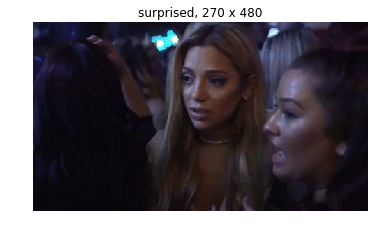

[400000   1816     10     50  18267  71497 400000    102   3553    203
    102  56563 400000   2926 400000 400000 400000 400000 400000 400000]
14


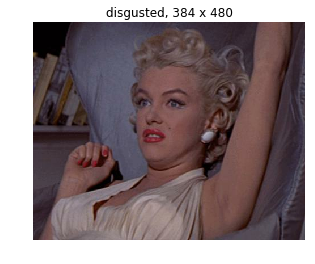

[    50  42475  71497  19834  11956  10278   7650  66902  22639  39204
   1970  18747     66   1957 400000 400000 400000 400000 400000 400000]
16


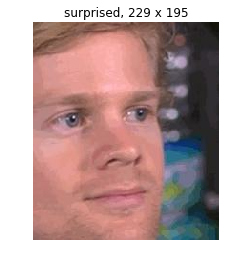

[   738    260    192   5450    662   3553    359     79     18    934
      4    192    927      5   3380    285     63    117 400000 400000]
18


In [2]:
import tensorflow as tf
from tensorflow.contrib import slim
import matplotlib.pyplot as plt
from datasets.convert_to_dataset import get_split_with_text
%matplotlib inline

with tf.Graph().as_default(): 
    dataset_dir = 'data'
    dataset = get_split_with_text('train', dataset_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1, shuffle=False)
    image, text, seq_len, label = data_provider.get(['image', 'text', 'seq_len', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(3):
                np_image, np_text, np_seq_len, np_label = sess.run([image, text, seq_len, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()
                print(np_text)
                print(np_seq_len)

In [1]:
from image_text_model.im_text_rnn_model import train_deep_sentiment

checkpoints_dir = 'image_model/pretrained_model'
train_dir = 'image_text_model/deep_sentiment_model'
num_steps = 5
train_deep_sentiment(checkpoints_dir, train_dir, num_steps)

Finished loading word embedding weights.
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
503
64
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
New learning rate: 0.001
INFO:tensorflow:global step 1: loss = 2.0720 (62.97 sec/step)
INFO:tensorflow:global step 2: loss = 2.5564 (33.07 sec/step)
INFO:tensorflow:global step 3: loss = 1.7036 (32.45 sec/step)
INFO:tensorflow:global step 4: loss = 1.7845 (32.84 sec/step)
INFO:tensorflow:global step 5: loss = 2.0672 (36.40 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.
Finished training.

In [ ]:
from image_text_model.im_text_rnn_model import evaluate_deep_sentiment

checkpoint_dir = 'image_text_model/deep_sentiment_model'
log_dir = 'image_text_model/model_eval'
mode = 'train'
num_evals = 2

evaluate_deep_sentiment(checkpoint_dir, log_dir, mode, num_evals)

## Image model

In [1]:
from image_model.im_model import train_image_model

checkpoints_dir = 'image_model/pretrained_model'
train_dir = 'image_model/finetuned_image_model'
num_steps = 5
train_image_model(checkpoints_dir, train_dir, num_steps)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
New learning rate: 0.001
INFO:tensorflow:global step 1: loss = 2.6359 (47.14 sec/step)
INFO:tensorflow:global step 2: loss = 2.1919 (30.08 sec/step)
INFO:tensorflow:global step 3: loss = 1.8378 (28.16 sec/step)
INFO:tensorflow:global step 4: loss = 1.8842 (31.41 sec/step)
INFO:tensorflow:global step 5: loss = 2.0303 (33.04 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.
Finished training. Last batch loss 2.030


In [ ]:
from image_model.im_model import evaluate_image_model

checkpoint_dir = 'image_model/finetuned_image_model'
log_dir = 'image_model/image_model_eval'
mode = 'train'
num_evals = 2

evaluate_image_model(checkpoint_dir, log_dir, mode, num_evals)

## Text model

In [2]:
from text_model.text_embedding import train_text_model

train_dir = 'text_model/trained_text_model'
num_steps = 5
train_text_model(train_dir, num_steps)

Finished loading word embedding weights.
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
New learning rate: 0.001
INFO:tensorflow:global step 1: loss = 2.0022 (9.12 sec/step)
INFO:tensorflow:global step 2: loss = 1.6834 (4.96 sec/step)
INFO:tensorflow:global step 3: loss = 2.7022 (4.18 sec/step)
INFO:tensorflow:global step 4: loss = 1.8037 (4.41 sec/step)
INFO:tensorflow:global step 5: loss = 1.7215 (4.00 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.
Finished training. Last batch 

In [ ]:
from text_model.text_embedding import evaluate_text_model

checkpoint_dir = 'text_model/trained_text_model'
log_dir = 'text_model/text_model_eval'
mode = 'train'
num_evals = 2

evaluate_text_model(checkpoint_dir, log_dir, mode, num_evals)

## Dataset

In [2]:
import os
import pandas as pd
from text_model.text_preprocessing import _load_embedding_weights_glove, preprocess_one_df

emotions = ['happy', 'sad', 'scared', 'angry', 'surprised', 'disgusted', 'annoyed', 'bored', 
'love', 'calm', 'amazed', 'optimistic', 'interested', 'pensive', 'ashamed', 'excited']

df_sizes = dict()
df_sizes_english = dict()

text_dir = 'text_model'
emb_dir = 'embedding_weights'
filename = 'glove.6B.50d.txt'
vocabulary, embedding = _load_embedding_weights_glove(text_dir, emb_dir, filename)
_POST_SIZE = 50
    
for emotion in emotions:
    path = os.path.join('data', emotion + '.csv')
    df = pd.read_csv(path, encoding='utf-8')
    df_sizes[emotion] = df.shape[0]
    df = preprocess_one_df(vocabulary, embedding, emotion, _POST_SIZE)
    df_sizes_english[emotion] = df.shape[0]
df_sizes_english

Finished loading word embedding weights.


{'amazed': 6331,
 'angry': 59899,
 'annoyed': 56783,
 'ashamed': 6315,
 'bored': 54546,
 'calm': 51807,
 'disgusted': 6349,
 'excited': 21551,
 'happy': 116930,
 'interested': 3510,
 'love': 40087,
 'optimistic': 10233,
 'pensive': 4762,
 'sad': 66747,
 'scared': 67756,
 'surprised': 8625}

In [12]:
df_sizes_image = {'amazed': 3580,
                  'angry': 20825,
                  'annoyed': 7430,
                  'ashamed': 2239,
                  'bored': 29169,
                  'calm': 41236,
                  'disgusted': 1594,
                  'excited': 15323,
                  'happy': 54905,
                  'interested': 1781,
                  'love': 26072,
                  'optimistic': 5783,
                  'pensive': 2897,
                  'sad': 18922,
                  'scared': 21202,
                  'surprised': 5845}

In [15]:
import operator
emotions_tuple = sorted(df_sizes.items(), key=operator.itemgetter(1), reverse=True)

for item in emotions_tuple:
    print(item[0].title() + ' & ' + format(item[1], ',') + ' & ' +\
          format(float(100 * df_sizes_english[item[0]]) / item[1], '.0f') + '\% & ' +\
          format(float(100 * df_sizes_image[item[0]]) / item[1], '.0f') + '\%' +' \\\\')

Happy & 189,841 & 62\% & 29\% \\
Calm & 139,911 & 37\% & 29\% \\
Sad & 124,900 & 53\% & 15\% \\
Scared & 104,161 & 65\% & 20\% \\
Bored & 101,856 & 54\% & 29\% \\
Angry & 100,033 & 60\% & 21\% \\
Annoyed & 72,993 & 78\% & 10\% \\
Love & 66,146 & 61\% & 39\% \\
Excited & 37,240 & 58\% & 41\% \\
Surprised & 18,322 & 47\% & 32\% \\
Optimistic & 16,111 & 64\% & 36\% \\
Amazed & 10,367 & 61\% & 35\% \\
Ashamed & 10,066 & 63\% & 22\% \\
Disgusted & 9,178 & 69\% & 17\% \\
Pensive & 8,409 & 57\% & 34\% \\
Interested & 5,606 & 63\% & 32\% \\


In [19]:
format(sum(df_sizes.values()), ',') + ' & ' + format(sum(df_sizes_english.values()), ',') + ' & ' +\
format(sum(df_sizes_image.values()), ',')

'1,015,140 & 582,231 & 258,803'

## Statistics

In [1]:
import os
import pandas as pd
from text_model.text_preprocessing import _load_embedding_weights_glove, preprocess_one_df

emotions = ['happy', 'sad', 'scared', 'angry', 'surprised', 'disgusted', 'annoyed', 'bored', 
'love', 'calm', 'amazed', 'optimistic', 'interested', 'pensive', 'ashamed', 'excited']

df_dict = dict()

text_dir = 'text_model'
emb_dir = 'embedding_weights'
filename = 'glove.6B.50d.txt'
vocabulary, embedding = _load_embedding_weights_glove(text_dir, emb_dir, filename)
_POST_SIZE = 50
    
for emotion in emotions:
    df = preprocess_one_df(vocabulary, embedding, emotion, _POST_SIZE)
    df_dict[emotion] = df

Finished loading word embedding weights.


In [2]:
columns = [          u'id',     u'post_url',         u'type',    u'timestamp',
               u'date',         u'tags',        u'liked',   u'note_count',
              u'photo',         u'text', u'search_query',    u'text_list',
           u'text_len']
df_all = pd.DataFrame(columns = [])

for emotion in emotions:
    df_all = pd.concat([df_all, df_dict[emotion]]).reset_index(drop=True)

In [3]:
df_all.describe()

,id,timestamp,note_count,text_len
count,5.822310e+05,5.822310e+05,582231.000000,582231.000000
mean,1.332861e+11,1.456783e+09,15.851834,53.464062
std,3.316374e+10,4.029440e+07,1358.772619,128.827916
min,2.576496e+09,1.294027e+09,0.000000,3.000000
25%,1.096066e+11,1.422651e+09,0.000000,12.000000
50%,1.504037e+11,1.473867e+09,0.000000,23.000000
75%,1.586848e+11,1.490143e+09,2.000000,48.000000
max,1.662284e+11,1.507581e+09,561474.000000,11310.000000


In [9]:
max(df_all['date'])

u'2017-10-09 20:35:24 GMT'

In [13]:
import numpy as np
np.mean(df_all['text_len'] <= 50)

0.76369001307041362

In [16]:
embedding.shape

(400000, 50)

In [19]:
str_emotions = ''
for emotion in emotions:
    str_emotions = str_emotions + emotion + ', '
str_emotions

'happy, sad, scared, angry, surprised, disgusted, annoyed, bored, love, calm, amazed, optimistic, interested, pensive, ashamed, excited, '